# <center>Practice 06. Decision Trees</center>
## <center>Part 01. Titanic EDA</center>

Повторим разведочный анализ датасета пассажиров "Титаника", который можно скачать [тут](https://www.kaggle.com/competitions/titanic/data).

Описание датасета:
- **PassengerId** ––– id пассажира, можно взять за индекс
- **Survived** (целевой признак) ––– выжил ли пассажир (0 = Нет, 1 = Да);
- **Pclass** ––– класс билета (1 = 1st, 2 = 2nd, 3 = 3rd);
- **Sex** ––– пол (female или male)	
- **Age** ––– возраст в годах
- **SibSp** –––	количество братьев, сестёр (в том числе сводных) и супругов на борту	
- **Parch**	–––	количество детей и родителей на борту
- **Ticket** ––– номер билета	
- **Fare** ––– стоимость проезда пассажира	
- **Cabin** ––– номер каюты	
- **Embarked** ––– порт посадки пассажира (C = Cherbourg, Q = Queenstown, S = Southampton).

Необходимо решить задачу классификации и научиться предсказывать целовой признак **Survived** выживет ли пассажир по его нецелевым признакам.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# устанавливаем точность чисел с плавающей точкой
%precision %.4f

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

df = pd.read_csv('../../data/titanic/titanic_train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


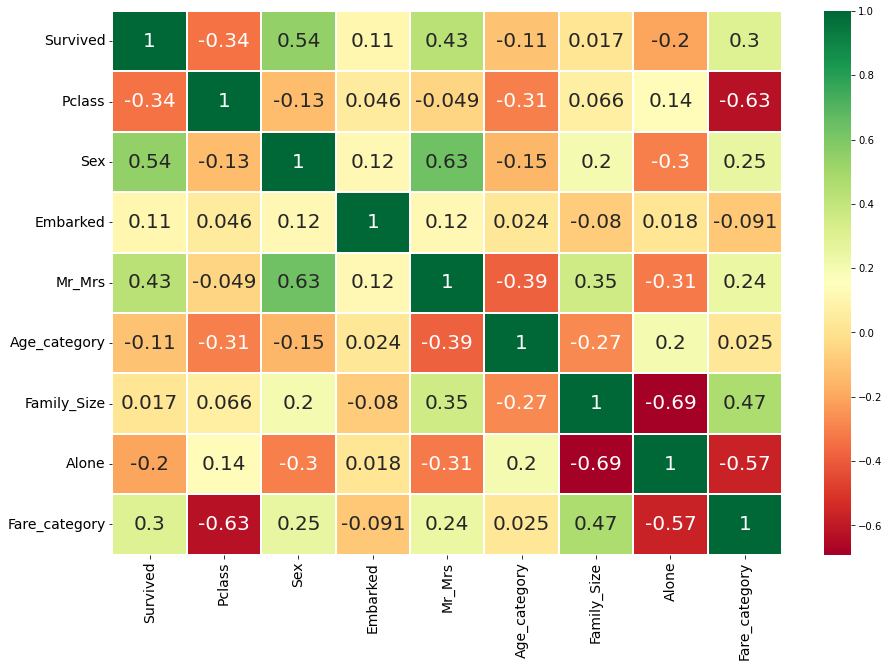

In [2]:
df['Mr_Mrs'] = 0
for i in df:
    df['Mr_Mrs']=df['Name'].str.extract('([A-Za-z]+)\.') # выделим обращения
df['Mr_Mrs'].\
replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],\
        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'], inplace=True)
df.loc[(df['Mr_Mrs'] == 'Mr') & (df['Sex'] == 'female'), "Mr_Mrs"] = 'Mrs' # исправляем обращение к доктору женщине

df.loc[(df['Age'].isnull()) & (df['Mr_Mrs'] == 'Master'), 'Age'] = 5
df.loc[(df['Age'].isnull()) & (df['Mr_Mrs'] == 'Miss'), 'Age'] = 22
df.loc[(df['Age'].isnull()) & (df['Mr_Mrs'] == 'Mr'), 'Age'] = 33
df.loc[(df['Age'].isnull()) & (df['Mr_Mrs'] == 'Mrs'), 'Age'] = 36
df.loc[(df['Age'].isnull()) & (df['Mr_Mrs'] == 'Other'), 'Age'] = 46

df['Embarked'].fillna('S', inplace=True)

df['Age_category'] = 0  # заполняем сначала значения нового признака нулями
df.loc[df['Age'] <= 16, 'Age_category'] = 0  # далле разбиваем возраста на 5 категорий
df.loc[(df['Age'] > 16) & (df['Age'] <= 32), 'Age_category'] = 1
df.loc[(df['Age'] > 32) & (df['Age'] <= 48), 'Age_category'] = 2
df.loc[(df['Age'] > 48) & (df['Age'] <= 64), 'Age_category'] = 3
df.loc[df['Age'] > 64, 'Age_category'] = 4

df['Family_Size'] = 0
df['Family_Size'] = df['Parch'] + df['SibSp']  # размер семьи
df['Alone'] = 0
df.loc[df['Family_Size'] == 0, 'Alone'] = 1  # путешествовал ли пассажир один

df['Fare_category'] = pd.qcut(df['Fare'], 5)
df['Fare_category'] = 0
df.loc[df['Fare'] <= 7.91, 'Fare_category'] = 0
df.loc[(df['Fare'] > 7.91) & (df['Fare'] <= 14.454), 'Fare_category'] = 1
df.loc[(df['Fare'] > 14.454) & (df['Fare'] <= 31), 'Fare_category'] = 2
df.loc[(df['Fare'] > 31) & (df['Fare'] <= 513), 'Fare_category'] = 3

df['Sex'].replace(['male', 'female'], [0, 1], inplace=True)
df['Embarked'].replace(['S', 'C', 'Q'], [0, 1, 2], inplace=True)
df['Mr_Mrs'].replace(['Mr', 'Mrs', 'Miss', 'Master', 'Other'], [0, 1, 2, 3, 4], inplace=True)

df.drop(['Name', 'Age', 'Ticket', 'SibSp', 'Parch', 'Fare', 'Cabin', 'PassengerId'], axis=1, inplace=True)
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', linewidths=0.2, annot_kws={'size':20})
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## <center>Part 02. Decision Trees</center>

### Simple train/test split using train_test_split()

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

cols = ["Pclass","Sex","Embarked","Mr_Mrs","Age_category","Family_Size","Alone","Fare_category"] 
X = df[cols]
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

### First model

In [4]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
print("train accuracy:", decision_tree.score(X_train, y_train))
print("test accuracy:", decision_tree.score(X_test, y_test))

train accuracy: 0.8876404494382022
test accuracy: 0.7988826815642458


### Scaling

In [5]:
scaler = StandardScaler()  # воспользуемся стандартным трансформером

# масштабируем обучающую выборку и запоминаем среднее, стандартное отклонение признаков
X_train_scaled = scaler.fit_transform(X_train)

# масштабируем тестовую выборку используя статистики обучающей выборки
X_test_scaled = scaler.transform(X_test)

decision_tree_scaled = DecisionTreeClassifier()
decision_tree_scaled.fit(X_train_scaled, y_train)
print("train accuracy:", decision_tree.score(X_train_scaled, y_train))
print("test accuracy:", decision_tree.score(X_test_scaled, y_test))

train accuracy: 0.6839887640449438
test accuracy: 0.7374301675977654


Решающие деревья не зависят от разброса значений признаков, их масштабов, выбросов, так сильно, как другие алгоритмы. Поэтому не нужно масштабировать выборку.

### Подбор гиперпараметров с помощью GridSearchCV и StratifiedKFold

Некоторые параметры sklearn.tree.DecisionTreeClassifier:

- criterion : {“gini”, “entropy”, “log_loss”}, default=”gini” –– функция для оценки качества разбиений 
- splitter : {“best”, “random”}, default=”best” –– стратегия разбиения для каждой вершины
- max_depth : int, default=None –– ограничение на максимальную глубину дерева
- min_samples_split : int or float, default=2 –– минимальное число (если float, то доля от выборки) объектов для продолжения разбиений
- min_samples_leaf : int or float, default=1 –– минимальное количество/доля объектов для вершин
- max_features: int, float or {“auto”, “sqrt”, “log2”}, default=None –– количество признаков для рассмотрения при выборе лучшего разбиения

Про гиперпараметры DecisionTreeClassifier можно найти информацию [тут](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
#from sklearn.metrics import accuracy_score

criterion = ["gini", "entropy", "log_loss"]
splitter = ["best", "random"]
max_depth = [2, 3, 4, 5, 10, 20]
min_samples_split = [2, 4, 5, 10]
min_samples_leaf = [1, 2, 4, 6]
max_features = [2, 4, 6, 8]

cv = StratifiedKFold(10)

decision_tree = DecisionTreeClassifier(random_state=42)
grid_dt = GridSearchCV(estimator=decision_tree, cv=cv, 
        param_grid=dict(criterion=criterion,splitter=splitter, max_depth=max_depth,
                        min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                        max_features= max_features))
grid_dt.fit(X_train, y_train)
print("best score: ", grid_dt.best_score_)
print("best param: ", grid_dt.best_params_)
print("test score:", grid_dt.score(X_test, y_test))
#print("test score:", accuracy_score(y_test, grid_dt.best_estimator_.predict(X_test)))

best score:  0.8370500782472613
best param:  {'criterion': 'gini', 'max_depth': 3, 'max_features': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
test score: 0.8268156424581006


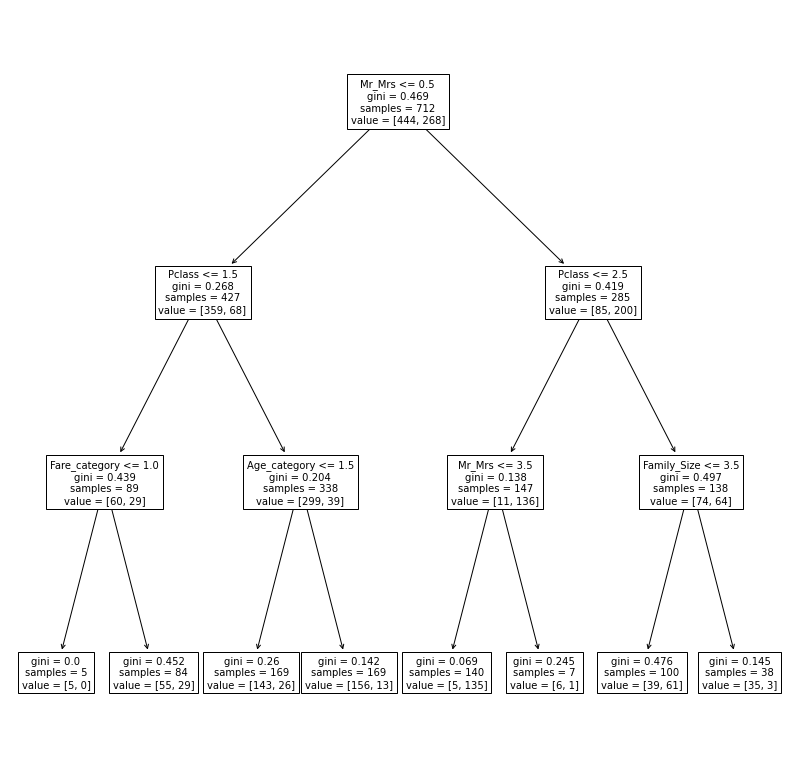

In [7]:
from sklearn import tree
final_decision_tree = grid_dt.best_estimator_

plt.figure(figsize=(14, 14))
tree.plot_tree(final_decision_tree, feature_names=["Pclass","Sex","Embarked","Mr_Mrs","Age_category","Family_Size","Alone","Fare_category"],fontsize=10);

In [8]:
df.head()

,Survived,Pclass,Sex,Embarked,Mr_Mrs,Age_category,Family_Size,Alone,Fare_category
0,0,3,0,0,0,1,1,0,0
1,1,1,1,1,1,2,1,0,3
2,1,3,1,0,2,1,0,1,1
3,1,1,1,0,1,2,1,0,3
4,0,3,0,0,0,2,0,1,1


In [9]:
#import graphviz
#dot_data = tree.export_graphviz(final_decision_tree, out_file=None) 
#graph = graphviz.Source(dot_data) 
#graph.render("titanic")